<a href="https://colab.research.google.com/github/jblss888/cs39aa_project/blob/main/Part3_Notebook_G_2nd_attempt_Juliet_Smith.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Part 3, Juliet Smith


This is an adaptation of NoteBook G For the yelp reviews. https://github.com/sgeinitz/cs39aa_notebooks/blob/main/nb_G_mlp_for_yelp_reviews.ipynb This particular notebook aligned more of what I thought I should initially do for my data. 

In [579]:
from argparse import Namespace
from collections import Counter
from nltk.corpus import stopwords
import json
import os
import re
import string
import seaborn as sns

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm
import matplotlib
import matplotlib.pyplot as plt

In [580]:
!pip install nltk 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [581]:
import nltk # This will help me break up sentences into individual words
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **The Vocabulary**

In [582]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="unk"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        print("here ", token_to_idx)
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

# **The Vectorizer**

I needed to alter this section so to fit my own data. I named review to sentence. I also renamed the rating _vocab to motion_vocab

In [583]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, sentence_vocab, motion_vocab):
        """
        Args:
            sentence_vocab (Vocabulary): maps words to integers
            motion_vocab (Vocabulary): maps class labels to integers
        """
        self.sentence_vocab = sentence_vocab
        self.motion_vocab = motion_vocab

    def vectorize(self, sentence):
        """Create a collapsed one-hit vector for the review
        
        Args:
            review (str): the review 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding 
        """
        one_hot = np.zeros(len(self.sentence_vocab), dtype=np.float32)
        
        for token in sentence.split(" "):
            if token not in string.punctuation:
                one_hot[self.sentence_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, sentence_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            sentence_df (pandas.DataFrame): the sentence dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        sentence_vocab = Vocabulary(add_unk=True)
        motion_vocab = Vocabulary(add_unk=False)
        stop_words = set(stopwords.words('english'))
        stop_words.remove("no")

        
        # Add ratings
        for motion in sorted(set(sentence_df.motion)):
            motion_vocab.add_token(motion)

        # Add top words if count > provided count
        word_counts = Counter()
        for sentence in sentence_df.sentence:
            for word in sentence.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff and word not in stop_words:
                sentence_vocab.add_token(word)

        return cls(sentence_vocab, motion_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        sentence_vocab = Vocabulary.from_serializable(contents['sentence_vocab'])
        motion_vocab =  Vocabulary.from_serializable(contents['motion_vocab'])

        return cls(sentence_vocab=sentence_vocab, motion_vocab=motion_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        return {'sentence_vocab': self.sentence_vocab.to_serializable(),
                'motion_vocab': self.motion_vocab.to_serializable()}

# **The Dataset**

In [584]:
class ReviewDataset(Dataset):
    def __init__(self, sentence_df, vectorizer):
        """
        Args:
            sentence_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.sentence_df = sentence_df
        self._vectorizer = vectorizer

        self.train_df = self.sentence_df.iloc[:20000,:]
        self.train_size = len(self.train_df)
# I don't have much time left so I decided to speed up training by using a smaller subset of the dataset
        self.val_df = self.sentence_df.iloc[20000:21000]
        self.validation_size = len(self.val_df)

        self.test_df = self.sentence_df.iloc[21000:,:]
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        sentence_df = pd.read_csv(review_csv)
        train_sentence_df = sentence_df.iloc[:10000,:]
        return cls(sentence_df, ReviewVectorizer.from_dataframe(train_sentence_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        sentence_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(sentence_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        sentence_vector = \
            self._vectorizer.vectorize(row.sentence)

        motion_index = \
            self._vectorizer.motion_vocab.lookup_token(row.motion)

        return {'x_data': sentence_vector,
                'y_target': motion_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is at the correct device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

# **The Model: ReviewClassifier**

In [585]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features, hidden_features, dropout_rate):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=16)
        self.fc3 = nn.Linear(in_features=16, out_features=1)
        #self.fc2 = nn.Linear(in_features=hidden_features, out_features=1)
        self.drop = dropout_rate
        
    def forward(self, x_in, apply_sigmoid=False, apply_dropout=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """
        out = self.fc1(x_in)
        out = F.relu(out)
        if apply_dropout:
            out = F.dropout(out, p=self.drop)
            
        out = self.fc2(out)
        out = F.relu(out)
        #if apply_dropout:
        #    out = F.dropout(out, p=self.drop)

        y_out = self.fc3(out).squeeze()
        #y_out = self.fc2(out).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

#**Training Routine**
## **Helper functions**

In [586]:
def make_train_state(args):
    return {'stop_early': True,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e6,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

### **General utilities**

In [587]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

## **Settings and prep work**

Most of the methods above I left as they were. This is where I start to use my own dataset to make changes to the code. 

### **Getting the database set up**

In [588]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [589]:
from datasets import load_dataset # this will let me load the dataset "LiMit" from Hugging Face


In [590]:
# Loaing "LiMiT" dataset from hugging face
dataset = load_dataset("limit")

  0%|          | 0/2 [00:00<?, ?it/s]

In [591]:
train = pd.DataFrame(dataset['train'])
val = pd.DataFrame(dataset['test'])

frames = [train, val]
print(train.shape)
print(val.shape)



(23559, 4)
(1000, 4)


In [592]:
# Because of how the vectorization is done I'm combining the validation and training set from the huggingface dataset
df = pd.concat(frames)
df.shape
df.head

<bound method NDFrame.head of       id                                           sentence motion  \
0      0       A little boy holding a yellow ball walks by.    yes   
1      1        The camel walks as the woman leans forward.    yes   
2      2   The man mixes up various ingredients and begi...    yes   
3      3   He continues laying tiles on the floor while ...    yes   
4      4  Then one man stands in a field holding a woode...    yes   
..   ...                                                ...    ...   
995  995            We see a man in the pool with a cap on.     no   
996  996  A man is seen kneeling on a floor and puts his...    yes   
997  997   the woman is in the hall and talk to the boys...     no   
998  998   A small brush with melted butter begins to bu...    yes   
999  999  a scene from th big bang theory is shown and t...     no   

                                       motion_entities  
0    [{'entity': 'little boy', 'start_index': 2}, {...  
1    [{'entity'

I used these resources to help me make directories to save my data and the  wieghts/hyperparams to my google drive. That way I don't loose my training if Colab deletes my variables, again

https://blog.roboflow.com/how-to-save-and-load-weights-in-google-colab/#identify-the-weights-file-path

https://cyublog.com/articles/python-en/colab-pandas-three-ways-to-save-dataframe-data/

In [593]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [594]:
!mkdir mydata

mkdir: cannot create directory ‘mydata’: File exists


In [595]:
path = '/content/mydata/dataset.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

In [611]:
# Setup information about how to name and locate data, hyperparams, etc.
args = Namespace(
    # Input data file (from preprocessing step)
    #input_data_path='gdrive/MyDrive/Colab Data/',
    input_data_path= '/content/mydata',
    review_csv= 'dataset.csv',
    # Output data and path information
    #frequency_cutoff=25,
    model_state_file='model.pth',
    #save_dir='gdrive/MyDrive/Colab Data/yelp_models/',
    save_dir='/content/mydata',
    vectorizer_file='vectorizer.json',
    # Training hyper parameters
    batch_size=500,
    early_stopping_criteria=3,
    learning_rate=0.002,
    num_epochs=100,
    seed=42,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=False,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

# Expand out the paths and confirm they are correct
if args.expand_filepaths_to_save_dir:
    args.review_csv = os.path.join(args.input_data_path, args.review_csv)
    args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)    
    print("Expanded filepaths: ")
    print("\t{}".format(args.review_csv))
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	/content/mydata/dataset.csv
	/content/mydata/vectorizer.json
	/content/mydata/model.pth
Using CUDA: False


### **Initializations**

In [597]:
if args.reload_from_files:
    # training from a checkpoint
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                            args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()

Loading dataset and creating vectorizer
here  None
here  None


### **Quick Data Exploration**

In [598]:
for i, tokflag in enumerate(dataset[4]['x_data']):
    if tokflag > 0:
#        print(f" pos i={i:4.0f} has a non-zero token value of: {tokflag} (original tok was: {vectorizer.sentence_vocab._idx_to_token[i]})")
        print(f" pos i={i:4.0f} has token value of: {tokflag} (token was: {vectorizer.sentence_vocab.lookup_index(i)})")

 pos i=   0 has token value of: 1.0 (token was: unk)
 pos i=   4 has token value of: 1.0 (token was: holding)
 pos i=  11 has token value of: 1.0 (token was: man)
 pos i=  15 has token value of: 1.0 (token was: begins)
 pos i=  25 has token value of: 1.0 (token was: Then)
 pos i=  26 has token value of: 1.0 (token was: one)
 pos i=  27 has token value of: 1.0 (token was: stands)
 pos i=  28 has token value of: 1.0 (token was: field)
 pos i=  29 has token value of: 1.0 (token was: wooden)
 pos i=  30 has token value of: 1.0 (token was: it.)


In [599]:
#vectorizer.sentence_vocab._token_to_idx
for key, val in vectorizer.sentence_vocab._idx_to_token.items():
  if key < 30:
    print(key, " -> ", val)

0  ->  unk
1  ->  A
2  ->  little
3  ->  boy
4  ->  holding
5  ->  yellow
6  ->  ball
7  ->  walks
8  ->  The
9  ->  camel
10  ->  woman
11  ->  man
12  ->  mixes
13  ->  various
14  ->  ingredients
15  ->  begins
16  ->  laying
17  ->  floor.
18  ->  He
19  ->  continues
20  ->  floor
21  ->  looking
22  ->  back
23  ->  speak
24  ->  camera.
25  ->  Then
26  ->  one
27  ->  stands
28  ->  field
29  ->  wooden


In [600]:
#vectorizer.motion_vocab._idx_to_token
vectorizer.motion_vocab._token_to_idx

{'no': 0, 'yes': 1}

### **Training loop**

In [612]:
# Declare/instantiate our model in a separate cell so that we can re-run
# it indepedently of other set up steps (in case we change model architecture)
classifier = ReviewClassifier(num_features=len(vectorizer.sentence_vocab), hidden_features=128, dropout_rate=0.25)

In [ ]:
import tqdm

classifier = classifier.to(args.device)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

losses = {'train':[], 'val':[]}

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float(), apply_dropout=True)

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            losses['train'].append(loss_t)
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            losses['val'].append(loss_t)
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)
        
        scheduler.step(train_state['val_loss'][-1])
        #optimizer.step()

        train_bar.n = 0
        val_bar.n = 0

        if train_state['stop_early']:
            print("Stopping early - validation is no longer significantly improving")
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/40 [00:00<?, ?it/s]

split=val:   0%|          | 0/2 [00:00<?, ?it/s]

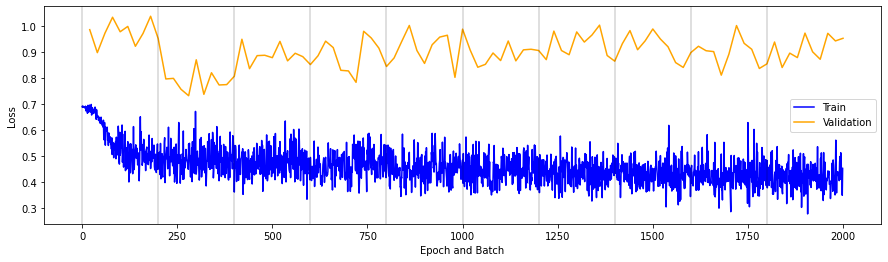

In [603]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue')
plt.plot(val_ticks, losses['val'], c='orange')
for i in range(args.num_epochs):
    plt.axvline(x=i*len(losses['train'])/args.num_epochs, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [604]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [605]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.849
Test Accuracy: 46.94


### **Inference**

In [606]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [607]:
def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    """Predict the rating of a review
    
    Args:
        review (str): the text of the review
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        decision_threshold (float): The numerical boundary which separates the rating classes
    """
    review = preprocess_text(review)
    
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))
    
    probability_value = torch.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.motion_vocab.lookup_index(index)

In [608]:
#test_review = "this is not a pretty awesome restaurant"
test_review = "the floors were dirty, but the food was good"
#test_review = "food was good, service was bad"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {}".format(test_review, prediction))

the floors were dirty, but the food was good -> no


### **Interpretability**

In [609]:
# Look at weights for first hidden unit
fc1_weights = classifier.fc1.weight.detach()[2]
_, indices = torch.sort(fc1_weights, dim=0, descending=False)
indices = indices.numpy().tolist()

# Top 20 words
print("Influential words that indicates No motion (in first hidden unit):")
print("-------------------------------------------------------------")
for i in range(20):
    print(vectorizer.sentence_vocab.lookup_index(indices[i]))
    
print("====\n\n\n")
indices.reverse()

# Top 20 negative words
print("Influential words for Yes there is motion (in first hidden unit):")
print("-------------------------------------------------------------")

for i in range(20):
    print(vectorizer.sentence_vocab.lookup_index(indices[i]))

Influential words that indicates No motion (in first hidden unit):
-------------------------------------------------------------
man
time
I
big
As
drops
woman
He
swimming
turns
holding
moves
well
watching
legs
river.
dance
talk
athlete
flips
====



Influential words for Yes there is motion (in first hidden unit):
-------------------------------------------------------------
left
screen.
go
cut
intro
ski
appears
forth
shown.
wearing
lifts
bowling
hair
stand
scene
horse
appear
There's
logo
shows


In [610]:
import torchsummary
torchsummary.summary(classifier, (1, dataset[0]['x_data'].shape[0]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]          64,000
            Linear-2                [-1, 1, 16]           2,064
            Linear-3                 [-1, 1, 1]              17
Total params: 66,081
Trainable params: 66,081
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.25
Estimated Total Size (MB): 0.26
----------------------------------------------------------------
